# 1) Setup & Imports

Dans cette section, on installe les packages nécessaires et on importe toutes les bibliothèques utilisées dans le projet :
- **Data** : pandas, numpy, yfinance, requests
- **Indicators** : pandas_ta
- **Models** : KMeans (clustering), RollingOLS (betas), LSTM (TensorFlow)
- **Portfolio optimization** : PyPortfolioOpt
- **Visualisation** : matplotlib


In [1]:
!pip -q install PyPortfolioOpt
!pip install pandas_ta

import pandas as pd
import numpy as np
import yfinance as yf
import requests
import pandas_ta as ta
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

import tensorflow as tf
from tensorflow.keras import layers, callbacks, models

import datetime as dt

# 2) Paramètres du projet

On fixe ici tous les hyperparamètres et réglages globaux :

- **Période d’étude** : 8 ans de données jusqu’au 27/09/2023  
- **Clustering** : KMeans avec `N_CLUSTERS=4`  
- **Sélection** : on garde les top actions dans les rôles *Gagnants dynamiques* et *Stables de qualité*  
- **Backtest / portefeuille** : fenêtre daily de 12 mois + contrainte de poids max par action  
- **Modèle prédictif** : LSTM sur séquences de 12 mois pour prédire le retour du mois suivant  
- **Reproductibilité** : seed fixé pour obtenir les mêmes résultats à chaque exécution


In [2]:
end_date = "2023-09-27"
start_date = (pd.to_datetime(end_date) - pd.DateOffset(years=8)).strftime("%Y-%m-%d")

N_CLUSTERS = 4
TOP_FRAC = 0.50         # sélection top 50% dans Winners & Stables
MIN_NAMES = 10          # minimum d’actions par rôle
MAX_NAMES = 60          # optionnel : plafond

LOOKBACK_MONTHS_DAILY = 12  # pour covariance et perf (fenêtre daily)
MAX_WEIGHT = 0.10

# LSTM
SEQ_LEN = 12            # 12 mois d'historique pour prédire le mois suivant
LSTM_EPOCHS = 30
BATCH_SIZE = 256
LR = 1e-3
RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 3) Collecte des données (S&P 500 + prix journaliers)

On récupère :
1. La liste des entreprises du **S&P 500** depuis Wikipedia (tickers).
2. Les prix journaliers OHLCV depuis **Yahoo Finance** via `yfinance`.

Le résultat est un DataFrame au format **MultiIndex** `(Date, Ticker)` avec les colonnes :
`Open, High, Low, Close, Adj Close, Volume`.

> Remarque : certains tickers contiennent un point (ex: `BRK.B`). Sur Yahoo Finance, on remplace `.` par `-` (ex: `BRK-B`).


In [3]:
# ============================================================
# DOWNLOAD S&P500 TICKERS (Wikipedia)
# ============================================================
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
sp500 = pd.read_html(response.text)[0]

sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-", regex=False)
symbols = sp500["Symbol"].unique().tolist()

print("Nb tickers (wiki):", len(symbols))

# ============================================================
# DOWNLOAD DAILY PRICES
# ============================================================
data = yf.download(symbols, start=start_date, end=end_date, auto_adjust=False, progress=False).stack()
df = data.copy()
df.columns.name = None

print("\nColonnes:", df.columns.tolist())
print("Nb tickers réellement téléchargés:", df.index.get_level_values("Ticker").nunique())
print("Période:", df.index.get_level_values("Date").min().date(), "→", df.index.get_level_values("Date").max().date())

display(df)

/tmp/ipython-input-524105187.py:7: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sp500 = pd.read_html(response.text)[0]


Nb tickers (wiki): 503


ERROR:yfinance:
6 Failed downloads:
ERROR:yfinance:['Q', 'VLTO', 'SNDK', 'GEV', 'MRSH', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-27 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443326400, endDate = 1695787200")')
/tmp/ipython-input-524105187.py:17: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = yf.download(symbols, start=start_date, end=end_date, auto_adjust=False, progress=False).stack()



Colonnes: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
Nb tickers réellement téléchargés: 497
Période: 2015-09-28 → 2023-09-26


Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-09-28 A        30.726622   33.369999   34.270000   33.320000   34.130001   
           AAPL     25.243671   28.110001   28.642500   28.110001   28.462500   
           ABBV     34.048645   52.500000   55.430000   52.340000   55.389999   
           ABT      32.004951   39.060001   40.740002   39.000000   40.740002   
           ACGL     22.992727   24.180000   24.243334   23.966667   24.056667   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     118.719467  124.010002  124.739998  123.449997  124.239998   
           ZBH     109.951439  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     172.425766  176.869995  178.449997  176.270004  176.580002   

                        Volume  
Date       Ticker               
2015-09-28 A         2615400.0  
           AAPL    208436000.0  
           ABBV     15123000.0  
           ABT      17219300.0  
           ACGL      1946700.0  
...                        ...  
2023-09-26 XYZ      10168200.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[972313 rows x 6 columns]

# 4) Feature engineering (données journalières)

On calcule des indicateurs journaliers utiles pour :
- **Volatilité** : `GK` (Garman–Klass) ≈ volatilité dans la même journée réalisée basée sur OHLC
- **Liquidité** : `dollar_volume` (Volume × Adj Close)
- **Momentum** : `RSI(20)`
- **Risque / volatilité** : `ATR(14)` (Average True Range)

Ces features seront ensuite agrégées au **niveau mensuel** pour faire le clustering et les prédictions.


In [4]:
# ============================================================
# 3) FEATURES DAILY
# ============================================================
df["GK"] = np.sqrt(np.maximum(
    0,
    0.5 * (np.log(df["High"] / df["Low"]))**2
    - (2 * np.log(2) - 1) * (np.log(df["Close"] / df["Open"]))**2
))

df["dollar_volume"] = (df["Volume"] * df["Adj Close"]) / 1e6
df["rsi"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: ta.rsi(close=x, length=20))

def compute_atr(stock_data):
    return ta.atr(high=stock_data["High"], low=stock_data["Low"], close=stock_data["Close"], length=14)

df["atr"] = df.groupby(level=1, group_keys=False).apply(compute_atr)


display(df.dropna())

Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-10-15 A        32.761555   35.580002   35.680000   34.790001   35.119999   
           AAPL     25.113453   27.965000   28.025000   27.622499   27.732500   
           ABBV     36.745373   56.139999   56.200001   53.849998   54.320000   
           ABT      34.506638   41.869999   42.029999   40.910000   41.070000   
           ACGL     24.330322   25.586666   25.606667   25.240000   25.253332   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     118.719467  124.010002  124.739998  123.449997  124.239998   
           ZBH     109.951439  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     172.425766  176.869995  178.449997  176.270004  176.580002   

                        Volume        GK  dollar_volume        rsi       atr  
Date       Ticker                                                             
2015-10-15 A         1433000.0  0.015926      46.947308  79.860224  0.818572  
           AAPL    150694000.0  0.008815    3784.446673  12.586147  0.646964  
           ABBV      7781600.0  0.022197     285.937793  75.787809  1.857857  
           ABT       7822000.0  0.014865     269.910919  82.005077  1.077857  
           ACGL      1433100.0  0.006130      34.867785  88.097608  0.380714  
...                        ...       ...            ...        ...       ...  
2023-09-26 XYZ      10168200.0  0.018393     455.637056  25.939817  1.908641  
           YUM       1500600.0  0.007260     178.150432  36.057140  1.860258  
           ZBH       3610500.0  0.016996     396.979670  31.893246  2.360510  
           ZBRA       355400.0  0.011547      79.595386  29.494977  6.949335  
           ZTS       1463200.0  0.008631     252.293381  42.623485  3.616068  

[965852 rows x 10 columns]

# 5) Passage en données mensuelles (resample)

Pour le clustering et la stratégie (rééquilibrage mensuel), on agrège les données journalières en **format mensuel**.

Règles d’agrégation utilisées :
- **Open** : premier jour du mois
- **High** : maximum du mois
- **Low** : minimum du mois
- **Close / Adj Close** : dernier jour du mois
- **Volume / dollar_volume** : somme mensuelle (activité totale)
- **GK** : moyenne mensuelle de la volatilité journalière
- **RSI / ATR** : valeur du dernier jour du mois (cohérent avec un signal fin de mois)

On ajoute ensuite `atr_pct = ATR / AdjClose`, une mesure de risque relative.


In [5]:
# ============================================================
# 4) RESAMPLE MONTHLY
# ============================================================
df1 = df.sort_index().reset_index().set_index("Date")

df_monthly = (
    df1.groupby("Ticker")
       .resample("M")
       .agg({
           "Open": "first",
           "High": "max",
           "Low": "min",
           "Close": "last",
           "Adj Close": "last",
           "Volume": "sum",
           "dollar_volume": "sum",
           "GK": "mean",
           "rsi": "last",
           "atr": "last"
       })
)

df1 = (df_monthly.reset_index()
       .set_index(["Date", "Ticker"])
       .sort_index()
       .dropna())

df1["atr_pct"] = df1["atr"] / df1["Adj Close"]

print("Monthly dataset created:", df1.shape)
display(df1)

/tmp/ipython-input-1224318283.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


Monthly dataset created: (46368, 11)


Open        High         Low       Close   Adj Close  \
Date       Ticker                                                               
2015-10-31 A        34.320000   38.099998   33.119999   37.759998   34.768867   
           AAPL     27.267500   30.305000   26.827499   29.875000   26.828693   
           ABBV     54.680000   60.730000   45.450001   59.549999   38.977329   
           ABT      40.349998   45.340000   39.279999   44.799999   36.921360   
           ACGL     24.613333   26.270000   24.126667   24.963333   23.737597   
...                       ...         ...         ...         ...         ...   
2023-09-30 XYZ      58.389999   59.720001   44.330002   44.810001   44.810001   
           YUM     129.929993  132.350006  123.449997  124.010002  118.719467   
           ZBH     119.610001  123.769997  112.419998  112.459999  109.951439   
           ZBRA    276.959991  278.760010  222.580002  223.960007  223.960007   
           ZTS     192.970001  193.350006  174.970001  176.869995  172.425766   

                         Volume  dollar_volume        GK        rsi       atr  \
Date       Ticker                                                               
2015-10-31 A       5.299330e+07    1755.928602  0.011861  80.302014  0.737763   
           AAPL    4.450048e+09  113557.733945  0.011658  34.131317  0.669370   
           ABBV    2.669152e+08    9347.820335  0.025533  67.417695  2.642857   
           ABT     1.734921e+08    6019.552126  0.012659  81.280391  0.909274   
           ACGL    3.011820e+07     725.476780  0.008494  65.600917  0.394141   
...                         ...            ...       ...        ...       ...   
2023-09-30 XYZ     1.936574e+08    9888.450048  0.019015  25.939817  1.908641   
           YUM     2.372670e+07    2891.083651  0.008523  36.057140  1.860258   
           ZBH     2.746270e+07    3207.702337  0.010700  31.893246  2.360510   
           ZBRA    7.240600e+06    1798.274678  0.013286  29.494977  6.949335   
           ZTS     2.694490e+07    4801.803270  0.011530  42.623485  3.616068   

                    atr_pct  
Date       Ticker            
2015-10-31 A       0.021219  
           AAPL    0.024950  
           ABBV    0.067805  
           ABT     0.024627  
           ACGL    0.016604  
...                     ...  
2023-09-30 XYZ     0.042594  
           YUM     0.015669  
           ZBH     0.021469  
           ZBRA    0.031029  
           ZTS     0.020972  

[46368 rows x 11 columns]

# 6) Filtre de liquidité + calcul des rendements mensuels

## 6.1 Filtre de liquidité (Top 150)
Pour éviter les actions peu liquides (spread élevé, prix bruités, impossible à trader), on conserve chaque mois uniquement les **actions les plus liquides**.

On utilise `dollar_volume` (Volume × Prix) agrégé au mois, puis on calcule une moyenne glissante sur **5 ans** (60 mois) afin de stabiliser la mesure de liquidité.

Ensuite, à chaque fin de mois, on garde les **150** actions avec le plus haut dollar_volume.

## 6.2 Rendements multi-horizons
On calcule des rendements mensuels sur plusieurs horizons : 1, 2, 3, 6, 9, 12 mois.
La formule utilisée correspond à un rendement “moyen par mois” (normalisé par l’horizon).
Ces features serviront au clustering et à la modélisation.


In [6]:
# ============================================================
# 5) LIQUIDITY FILTER TOP 150 (rolling 5 years monthly mean)
# ============================================================
df1["dollar_volume"] = df1["dollar_volume"].unstack("Ticker").rolling(5*12, min_periods=12).mean().stack()
df1["classement"] = df1.groupby("Date")["dollar_volume"].rank(ascending=False)
df1 = df1[df1["classement"] < 150].drop(["dollar_volume", "classement"], axis=1)

# ============================================================
# 6) MONTHLY RETURNS (1,2,3,6,9,12m annualized-ish as you did)
# ============================================================
def calculate_returns(g):
    for i in [1,2,3,6,9,12]:
        g[f"return_{i}m"] = (g["Adj Close"].pct_change(i).add(1).pow(1/i).sub(1))
    return g

df1 = df1.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

display(df1)

Open        High         Low       Close   Adj Close  \
Date       Ticker                                                               
2017-09-30 AAPL     41.200001   41.235001   37.290001   38.529999   35.964367   
           ABBV     75.589996   90.949997   74.730003   88.860001   62.180603   
           ABT      51.029999   54.799999   50.639999   53.360001   45.904259   
           ACN     130.949997  138.699997  129.100006  135.070007  118.876755   
           ADBE    155.759995  157.889999  143.949997  149.179993  149.179993   
...                       ...         ...         ...         ...         ...   
2023-09-30 WDAY    246.539993  252.720001  228.559998  229.240005  229.240005   
           WFC      41.549999   43.740002   40.299999   40.650002   38.418465   
           WMT      54.290001   55.283333   53.303333   54.166668   52.821438   
           XOM     112.199997  118.839996  112.199997  116.410004  107.600937   
           XYZ      58.389999   59.720001   44.330002   44.810001   44.810001   

                         Volume        GK        rsi       atr   atr_pct  \
Date       Ticker                                                          
2017-09-30 AAPL    2.721496e+09  0.009763  45.768878  0.651081  0.018104   
           ABBV    1.922700e+08  0.014409  70.568500  1.967963  0.031649   
           ABT     1.250395e+08  0.007494  63.664994  0.811059  0.017669   
           ACN     5.082070e+07  0.007929  56.250132  1.871653  0.015744   
           ADBE    5.508500e+07  0.008799  47.932484  2.460673  0.016495   
...                         ...       ...        ...       ...       ...   
2023-09-30 WDAY    2.205610e+07  0.010539  43.976804  5.007694  0.021845   
           WFC     2.961534e+08  0.012576  40.920259  0.921229  0.023979   
           WMT     2.850591e+08  0.006472  54.722524  0.579568  0.010972   
           XOM     2.609934e+08  0.010058  59.440186  2.103267  0.019547   
           XYZ     1.936574e+08  0.019015  25.939817  1.908641  0.042594   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
Date       Ticker                                                          
2017-09-30 AAPL    -0.060244   0.019956   0.024187   0.013139   0.033672   
           ABBV     0.180080   0.127414   0.073326   0.056376   0.042995   
           ABT      0.047507   0.041630   0.033465   0.033071   0.039285   
           ACN      0.032961   0.023971   0.029801   0.021839   0.017126   
           ADBE    -0.038541   0.009140   0.017918   0.023031   0.042073   
...                      ...        ...        ...        ...        ...   
2023-09-30 WDAY    -0.062413  -0.016777   0.004919   0.017531   0.035597   
           WFC     -0.015500  -0.057917  -0.013554   0.016712   0.000702   
           WMT     -0.000676   0.010014   0.012354   0.017574   0.016553   
           XOM      0.046947   0.046139   0.030496   0.012838   0.008747   
           XYZ     -0.222723  -0.254052  -0.123607  -0.068630  -0.036876   

                   return_12m  
Date       Ticker              
2017-09-30 AAPL      0.027658  
           ABBV      0.032249  
           ABT       0.021639  
           ACN       0.010139  
           ADBE      0.026857  
...                       ...  
2023-09-30 WDAY      0.034709  
           WFC       0.003255  
           WMT       0.020256  
           XOM       0.027037  
           XYZ      -0.016915  

[10463 rows x 16 columns]

# 7) Facteurs Fama-French + betas glissants (RollingOLS)

Objectif :
- Ajouter une dimension “style / risque” aux actions via les facteurs Fama-French
- Estimer des **expositions (betas)** qui évoluent dans le temps

Étapes :
1. Charger les facteurs Fama-French depuis `fama_french.csv` (format quotidien)
2. Convertir en format mensuel
3. Joindre `return_1m` de chaque action
4. Estimer des betas glissants avec une régression OLS sur une fenêtre de 24 mois


In [7]:
# ============================================================
# 7) FAMA-FRENCH + ROLLING BETAS
#    (Garde ta logique "RF négligeable": on drop RF)
# ============================================================
fama_french = pd.read_csv("fama_french.csv", skiprows=4).drop("RF", axis=1, errors="ignore")
fama_french.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
fama_french["Date"] = pd.to_datetime(fama_french["Date"], format="%Y%m%d")
fama_french = fama_french.set_index("Date").sort_index()
fama_french = fama_french / 100
fama_french = fama_french[fama_french.index >= "2017-01-01"].resample("M").mean()

# join return_1m to factors per ticker -> multiindex (Date,Ticker)
ff = fama_french.join(df1["return_1m"]).sort_index()

# filter tickers with min history
counts = ff.groupby(level=1).size()
valid = counts[counts >= 10].index
ff = ff[ff.index.get_level_values("Ticker").isin(valid)]

# rolling OLS per ticker
betas = (
    ff.groupby(level=1, group_keys=False)
      .apply(lambda x: RollingOLS(
          endog=x["return_1m"],
          exog=sm.add_constant(x.drop("return_1m", axis=1)),
          window=min(24, x.shape[0]),
          min_nobs=len(x.columns)+1
      ).fit(params_only=True).params.drop("const", axis=1))
)

factors = [c for c in fama_french.columns]

# join betas shifted -> avoid leakage
df1 = df1.join(betas.groupby("Ticker").shift())

# fill remaining betas with mean per ticker
df1.loc[:, factors] = df1.groupby("Ticker", group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
df1 = df1.dropna()

print("df1 after adding rolling betas:", df1.shape)

/tmp/ipython-input-3440820258.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fama_french = fama_french[fama_french.index >= "2017-01-01"].resample("M").mean()


df1 after adding rolling betas: (10196, 21)


# 8) Clustering mensuel (KMeans) — avec standardisation

Objectif : regrouper les actions chaque mois en “familles” similaires selon leurs caractéristiques (momentum, volatilité, exposition aux facteurs, etc.).

Points importants :
- On fait le clustering **mois par mois** (car le marché change dans le temps)
- On standardise les features **au sein de chaque mois** (`StandardScaler`) :
  - sinon une feature (ex: volatilité) pourrait dominer le clustering uniquement à cause de son échelle


In [8]:
# ============================================================
# 8) BUILD FEATURE SET FOR CLUSTERING
# ============================================================
drop_cols = ["Volume","Open","High","Low","Close","Adj Close","atr"]
features = [c for c in df1.columns if c not in drop_cols]
df_feat = df1[features].copy()

# ============================================================
# CLUSTERING MONTH-BY-MONTH WITH STANDARDIZATION (FIX)
# ============================================================
def get_clusters_one_month(g, n_clusters=N_CLUSTERS, random_state=0):
    X = g.values
    Xs = StandardScaler().fit_transform(X)  # standardisation within the month
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = km.fit_predict(Xs)
    out = g.copy()
    out["cluster"] = labels
    return out

df_clustered = df_feat.dropna().groupby("Date", group_keys=False).apply(get_clusters_one_month)

print("Clustered dataset:", df_clustered.shape)
display(df_clustered.head())

Clustered dataset: (10196, 15)


GK        rsi   atr_pct  return_1m  return_2m  \
Date       Ticker                                                        
2017-09-30 AAPL    0.009763  45.768878  0.018104  -0.060244   0.019956   
           ABBV    0.014409  70.568500  0.031649   0.180080   0.127414   
           ABT     0.007494  63.664994  0.017669   0.047507   0.041630   
           ACN     0.007929  56.250132  0.015744   0.032961   0.023971   
           ADBE    0.008799  47.932484  0.016495  -0.038541   0.009140   

                   return_3m  return_6m  return_9m  return_12m     Mkt-RF  \
Date       Ticker                                                           
2017-09-30 AAPL     0.024187   0.013139   0.033672    0.027658  26.119681   
           ABBV     0.073326   0.056376   0.042995    0.032249  10.782348   
           ABT      0.033465   0.033071   0.039285    0.021639  18.250714   
           ACN      0.029801   0.021839   0.017126    0.010139  25.163337   
           ADBE     0.017918   0.023031   0.042073    0.026857  23.447905   

                        SMB        HML        RMW        CMA  cluster  
Date       Ticker                                                      
2017-09-30 AAPL   -3.766853 -11.945099  18.515412   7.416104        2  
           ABBV    6.575201   0.132606   1.436594   2.463213        0  
           ABT    -3.315048 -10.978290   5.828091  19.639448        2  
           ACN    -3.063848  -5.825966   6.367901   1.512974        2  
           ADBE   -6.014644  -3.127997  -3.335185 -15.626848        2

# 9) Interpréter les clusters : attribution de rôles + scores

Le clustering (KMeans) donne des labels `0,1,2,3` qui ne veulent rien dire directement.
Pour rendre le modèle interprétable, on attribue à chaque cluster un **rôle** à partir de profils moyens :

- **Gagnants dynamiques** : forts rendements passés (momentum)
- **Stables de qualité** : profil “qualité” (ex : RMW élevé) et risque modéré
- **Sous pression** : mauvais rendement + volatilité élevée
- **Volatils neutres** : le(s) cluster(s) restant(s)

Méthode :
1. Pour un mois donné, on calcule la moyenne des features par cluster
2. On construit 4 scores (Trend, Risk, Quality, Stress)
3. On assigne un rôle unique à chaque cluster (mapping sans conflit)
4. On répète pour tous les mois


In [9]:
# ============================================================
# 9) ROLE + SCORES (as you did)
# ============================================================
def add_cluster_roles(df_month):
    g = df_month.copy()
    feats = [c for c in g.columns if c != "cluster"]
    prof = g.groupby("cluster")[feats].mean(numeric_only=True)

    trend = 0.45*prof["return_12m"] + 0.35*prof["return_6m"] + 0.20*prof["return_3m"] + 0.05*(prof["rsi"]/100)
    risk  = 1.00*prof["GK"] + 1.00*prof["atr_pct"]
    quality = 1.00*prof["RMW"] - 0.30*prof["GK"]
    stress  = -1.00*prof["return_12m"] + 0.80*prof["GK"] + 0.20*((50 - prof["rsi"])/50)

    scores = pd.DataFrame({
        "TrendScore": trend,
        "RiskScore": risk,
        "QualityScore": quality,
        "StressScore": stress
    })

    role_map = {}
    cl_win = scores["TrendScore"].idxmax()
    role_map[cl_win] = "Gagnants dynamiques"

    remaining = scores.index.difference(role_map.keys())
    cl_stress = scores.loc[remaining, "StressScore"].idxmax()
    role_map[cl_stress] = "Sous pression"

    remaining = scores.index.difference(role_map.keys())
    stable_metric = scores.loc[remaining, "QualityScore"] - 0.5*scores.loc[remaining, "RiskScore"]
    cl_stable = stable_metric.idxmax()
    role_map[cl_stable] = "Stables de qualité"

    remaining = scores.index.difference(role_map.keys())
    for cl in remaining:
        role_map[cl] = "Volatils neutres"

    g["role"] = g["cluster"].map(role_map)
    g = g.join(scores, on="cluster")
    return g, role_map

def apply_roles_all_months(df_in):
    out = []
    role_maps = {}
    for d in df_in.index.get_level_values("Date").unique().sort_values():
        g = df_in.xs(d, level=0).copy()
        g2, rmap = add_cluster_roles(g)
        g2["Date"] = d
        out.append(g2)
        role_maps[d] = rmap
    df_roles = (pd.concat(out)
                .reset_index()
                .set_index(["Date","Ticker"])
                .sort_index())
    return df_roles, role_maps

df1_roles, role_maps = apply_roles_all_months(df_clustered)

print("df1_roles:", df1_roles.shape)
display(df1_roles.head())

df1_roles: (10196, 20)


GK        rsi   atr_pct  return_1m  return_2m  \
Date       Ticker                                                        
2017-09-30 AAPL    0.009763  45.768878  0.018104  -0.060244   0.019956   
           ABBV    0.014409  70.568500  0.031649   0.180080   0.127414   
           ABT     0.007494  63.664994  0.017669   0.047507   0.041630   
           ACN     0.007929  56.250132  0.015744   0.032961   0.023971   
           ADBE    0.008799  47.932484  0.016495  -0.038541   0.009140   

                   return_3m  return_6m  return_9m  return_12m     Mkt-RF  \
Date       Ticker                                                           
2017-09-30 AAPL     0.024187   0.013139   0.033672    0.027658  26.119681   
           ABBV     0.073326   0.056376   0.042995    0.032249  10.782348   
           ABT      0.033465   0.033071   0.039285    0.021639  18.250714   
           ACN      0.029801   0.021839   0.017126    0.010139  25.163337   
           ADBE     0.017918   0.023031   0.042073    0.026857  23.447905   

                        SMB        HML        RMW        CMA  cluster  \
Date       Ticker                                                       
2017-09-30 AAPL   -3.766853 -11.945099  18.515412   7.416104        2   
           ABBV    6.575201   0.132606   1.436594   2.463213        0   
           ABT    -3.315048 -10.978290   5.828091  19.639448        2   
           ACN    -3.063848  -5.825966   6.367901   1.512974        2   
           ADBE   -6.014644  -3.127997  -3.335185 -15.626848        2   

                                  role  TrendScore  RiskScore  QualityScore  \
Date       Ticker                                                             
2017-09-30 AAPL     Stables de qualité    0.045936   0.025265      7.716332   
           ABBV    Gagnants dynamiques    0.086040   0.039285     -5.796118   
           ABT      Stables de qualité    0.045936   0.025265      7.716332   
           ACN      Stables de qualité    0.045936   0.025265      7.716332   
           ADBE     Stables de qualité    0.045936   0.025265      7.716332   

                   StressScore  
Date       Ticker               
2017-09-30 AAPL      -0.034586  
           ABBV      -0.090670  
           ABT       -0.034586  
           ACN       -0.034586  
           ADBE      -0.034586

# 10) Construction de l’univers investissable (sélection top actions par rôle)

À chaque fin de mois, on ne garde pas toutes les actions :
- on sélectionne seulement les meilleures actions dans les rôles
  - **Gagnants dynamiques** (triés par `TrendScore`)
  - **Stables de qualité** (triés par `QualityScore`)

La sélection est :
- **Top fraction** : ex. top 50% (`TOP_FRAC = 0.50`)
- avec une contrainte de taille :
  - au moins `MIN_NAMES`
  - au plus `MAX_NAMES`

Résultat :
- un dictionnaire `universes` qui contient, pour chaque mois, la liste des tickers “winners” et “stables”.


In [10]:
# ============================================================
# 10) BUILD UNIVERSE (top selection within roles)
# ============================================================
def select_top_fraction(df_month, role_name, score_col, top_frac=TOP_FRAC, min_names=MIN_NAMES, max_names=MAX_NAMES):
    sub = df_month[df_month["role"] == role_name].copy().dropna(subset=[score_col])
    if sub.empty:
        return []
    sub = sub.sort_values(score_col, ascending=False)
    n = int(np.ceil(len(sub) * top_frac))
    n = max(min_names, n)
    n = min(max_names, n)
    n = min(len(sub), n)
    return sub.index[:n].tolist()

def build_universe_by_month(df_roles):
    universes = {}
    dates = df_roles.index.get_level_values("Date").unique().sort_values()
    for d in dates:
        m = df_roles.xs(d, level=0)
        winners = select_top_fraction(m, "Gagnants dynamiques", "TrendScore")
        stables = select_top_fraction(m, "Stables de qualité", "QualityScore")
        universes[d] = {"winners": winners, "stables": stables}
    return universes

universes = build_universe_by_month(df1_roles)

# 11) Construction du dataset LSTM (uniquement actions sélectionnées)

Objectif :
- Entraîner **un seul modèle LSTM global** (toutes actions confondues)
- Prédire le **return_1m du mois suivant** à partir des **SEQ_LEN derniers mois**

On ne prend pas toutes les actions :
- On utilise uniquement les tickers sélectionnés chaque mois dans l’univers :
  - `winners` + `stables`

Pour chaque couple (Date signal = d, Ticker = t) :
- **X** = matrice (SEQ_LEN × nb_features) des features sur les SEQ_LEN derniers mois jusqu’à *d*
- **y** = `return_1m` réalisé au mois suivant (*d+1M*)

Important (anti look-ahead) :
- les features utilisées dans X sont disponibles à la fin du mois *d*
- la cible y appartient au mois *d+1*


In [11]:
# ============================================================
# 11) LSTM DATASET CREATION (only SELECTED actions after clustering)
#     Target: next month return_1m
# ============================================================
# features for ML (include everything except labels)
ML_DROP = ["cluster","role"]  # keep scores + factors + techs
ml_features = [c for c in df1_roles.columns if c not in ML_DROP]

# We build a table for sequences per ticker, but only for months where ticker is selected
def make_lstm_dataset(df_roles, universes, seq_len=SEQ_LEN):
    rows = []
    dates = df_roles.index.get_level_values("Date").unique().sort_values()

    for d in dates:
        sel = list(dict.fromkeys(universes[d]["winners"] + universes[d]["stables"]))
        if not sel:
            continue

        # for each selected ticker at signal date d, we want:
        # X = previous seq_len months ending at d (inclusive), y = return_1m at next month (d+1M)
        next_d = (pd.Timestamp(d) + pd.offsets.MonthEnd(1)).normalize()
        for t in sel:
            # extract history for this ticker up to d
            g = df_roles.xs(t, level=1).sort_index()
            if d not in g.index or next_d not in g.index:
                continue
            idx_pos = g.index.get_loc(d)
            if idx_pos - (seq_len-1) < 0:
                continue

            window = g.iloc[idx_pos-(seq_len-1):idx_pos+1][ml_features].copy()

            # target: next month return_1m
            y = g.loc[next_d, "return_1m"]
            if window.isna().any().any() or pd.isna(y):
                continue

            rows.append({
                "Date": d,
                "Ticker": t,
                "X": window.values.astype(np.float32),
                "y": float(y)
            })

    if not rows:
        raise ValueError("Dataset LSTM vide. Essaie de réduire SEQ_LEN ou d'élargir la sélection.")

    df_ds = pd.DataFrame(rows)
    return df_ds

ds = make_lstm_dataset(df1_roles, universes, seq_len=SEQ_LEN)
print("Nb samples LSTM:", len(ds))
display(ds)

Nb samples LSTM: 2229


,Date,Ticker,X,y
0,2018-08-31,AAPL,"[[0.009763067, 45.76888, 0.018103503, -0.06024...",-0.008303
1,2018-08-31,ABT,"[[0.007494143, 63.664993, 0.0176685, 0.0475068...",0.097546
2,2018-08-31,ADBE,"[[0.008798837, 47.932484, 0.016494658, -0.0385...",0.024439
3,2018-08-31,AMGN,"[[0.010598632, 61.74094, 0.02071839, 0.0488270...",0.037436
4,2018-08-31,AMZN,"[[0.007917941, 47.25329, 0.014958376, -0.01963...",-0.004824
...,...,...,...,...
2224,2023-08-31,HD,"[[0.014641765, 43.46792, 0.030881407, -0.04327...",-0.084045
2225,2023-08-31,HUM,"[[0.015836725, 49.768932, 0.028130846, 0.00868...",0.067955
2226,2023-08-31,IBM,"[[0.01182889, 32.575375, 0.024685426, -0.07504...",-0.024450
2227,2023-08-31,ISRG,"[[0.018499702, 35.5106, 0.03479652, -0.0889472...",-0.070168


# 12) Découpage Train / Validation / Test (split temporel)

Comme on travaille sur des séries temporelles, on ne fait **pas** de split aléatoire.
On découpe chronologiquement :

- **Train** : ~70% des mois (apprentissage)
- **Validation** : ~15% (tuning / early stopping)
- **Test** : ~15% (évaluation finale)

Ainsi, on respecte la contrainte “on apprend sur le passé, on teste sur le futur”.


In [12]:
# ============================================================
# 12) TRAIN / VAL / TEST SPLIT (time-based)
# ============================================================
ds["Date"] = pd.to_datetime(ds["Date"])
dates_sorted = ds["Date"].sort_values().unique()

# simple split by quantiles
cut1 = int(len(dates_sorted) * 0.70)
cut2 = int(len(dates_sorted) * 0.85)
train_dates = set(dates_sorted[:cut1])
val_dates   = set(dates_sorted[cut1:cut2])
test_dates  = set(dates_sorted[cut2:])

train = ds[ds["Date"].isin(train_dates)].copy()
val   = ds[ds["Date"].isin(val_dates)].copy()
test  = ds[ds["Date"].isin(test_dates)].copy()

X_train = np.stack(train["X"].values)
y_train = train["y"].values.astype(np.float32)

X_val = np.stack(val["X"].values)
y_val = val["y"].values.astype(np.float32)

X_test = np.stack(test["X"].values)
y_test = test["y"].values.astype(np.float32)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Shapes: (1551, 12, 18) (317, 12, 18) (361, 12, 18)


# 13) Normalisation + entraînement du modèle LSTM

## 13.1 Normalisation
Avant d’entraîner un LSTM, on normalise les features :
- on **fit** le scaler uniquement sur le **train** (pour éviter toute fuite d’information)
- on applique la transformation sur train / val / test
- on standardise **chaque feature** sur l’ensemble des timesteps (reshape 2D)

## 13.2 Modèle LSTM
Architecture :
- 2 couches LSTM (64 puis 32 unités)
- Dropout pour réduire l’overfitting
- Dense final → prédiction d’un seul nombre : `return_1m` du mois suivant

On utilise :
- loss = MSE
- EarlyStopping sur `val_loss`


In [13]:
# ============================================================
# 13) NORMALIZE FEATURES (global scaler on training set)
#     We scale per feature across all timesteps.
# ============================================================
n_features = X_train.shape[-1]
scaler = StandardScaler()

X_train_2d = X_train.reshape(-1, n_features)
X_val_2d   = X_val.reshape(-1, n_features)
X_test_2d  = X_test.reshape(-1, n_features)

scaler.fit(X_train_2d)

X_train_s = scaler.transform(X_train_2d).reshape(X_train.shape)
X_val_s   = scaler.transform(X_val_2d).reshape(X_val.shape)
X_test_s  = scaler.transform(X_test_2d).reshape(X_test.shape)

# ============================================================
# BUILD & TRAIN LSTM
# ============================================================
tf.keras.backend.clear_session()

model = models.Sequential([
    layers.Input(shape=(SEQ_LEN, n_features)),
    layers.Masking(mask_value=0.0),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="mse"
)

cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

hist = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=LSTM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=cb
)

# evaluation
test_pred = model.predict(X_test_s, verbose=0).reshape(-1)
mse = np.mean((test_pred - y_test)**2)
mae = np.mean(np.abs(test_pred - y_test))

print("Test MSE:", mse)
print(f"Test MAE: {mae:.6f}")


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - loss: 0.0177 - val_loss: 0.0100
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0107 - val_loss: 0.0098
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0097 - val_loss: 0.0097
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0084 - val_loss: 0.0096
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0086 - val_loss: 0.0096
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0088 - val_loss: 0.0095
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0085 - val_loss: 0.0095
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0081 - val_loss: 0.0094
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0081 - val_loss: 0.0094
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0078 - val_loss: 0.00

# 14) Prédire le rendement du mois suivant (Expected Return)

Une fois le LSTM entraîné, on prédit `return_1m` du mois suivant pour chaque observation (Date, Ticker) présente dans notre dataset LSTM.

Résultat :
- `pred_df` : table indexée `(Date, Ticker)` contenant `pred_return_next`
- Ces prédictions seront utilisées comme **expected returns** (`mu_pred`) dans la construction du portefeuille.


In [14]:
# ============================================================
# 14) PREDICT NEXT MONTH RETURN FOR EACH (Date, Ticker) sample
#     We store predictions aligned with "signal date" d
# ============================================================
X_all = np.stack(ds["X"].values)
X_all_s = scaler.transform(X_all.reshape(-1, n_features)).reshape(X_all.shape)
ds["pred_return_next"] = model.predict(X_all_s, verbose=0).reshape(-1)

pred_df = (ds[["Date","Ticker","pred_return_next"]]
           .set_index(["Date","Ticker"])
           .sort_index())

display(pred_df)

pred_return_next
Date       Ticker                  
2018-08-31 AAPL           -0.007289
           ABT            -0.000517
           ADBE           -0.037954
           AMGN           -0.008366
           AMZN           -0.052704
...                             ...
2023-08-31 HUM            -0.012760
           IBM            -0.039712
           ISRG            0.055876
           JNJ            -0.005241
           VLO             0.045903

[2229 rows x 1 columns]

# 15) Téléchargement des prix journaliers (pour le backtest)

Même si le clustering et le modèle LSTM sont mensuels, le backtest du portefeuille a besoin des prix **journaliers** :

- calcul de la covariance (risque) sur une fenêtre daily (ex : 12 mois)
- simulation de la performance entre le début et la fin du mois suivant

On télécharge donc les prix `Adj Close` de tous les tickers présents dans `df1_roles`.


In [15]:
# ============================================================
# 15) PRICES DAILY (needed for backtest)
# ============================================================
all_tickers = df1_roles.index.get_level_values("Ticker").unique().tolist()
start_prices = (df1_roles.index.get_level_values("Date").min() - pd.DateOffset(months=LOOKBACK_MONTHS_DAILY+1)).strftime("%Y-%m-%d")
end_prices   = (df1_roles.index.get_level_values("Date").max() + pd.DateOffset(months=1)).strftime("%Y-%m-%d")

prices_daily = yf.download(all_tickers, start=start_prices, end=end_prices, auto_adjust=False, progress=False)["Adj Close"]
if isinstance(prices_daily, pd.Series):
    prices_daily = prices_daily.to_frame()

prices_daily = prices_daily.dropna(how="all")
print("prices_daily:", prices_daily.shape)

prices_daily: (1803, 156)


# 16) Fonctions utilitaires pour le backtest mensuel

On a besoin de fonctions pour :
- récupérer la période de holding (mois suivant)
- optimiser un portefeuille Markowitz en utilisant :
  - la covariance calculée sur les prix journaliers
  - les expected returns prédits par le LSTM (`mu_pred`)
- proposer une baseline simple : equal-weight sur les actions sélectionnées


In [16]:
# ============================================================
# 16) HELPERS FOR MONTH BACKTEST
# ============================================================
def month_period(d):
    d = pd.Timestamp(d)
    start = (d + pd.offsets.MonthBegin(1)).normalize()
    end   = (d + pd.offsets.MonthEnd(1)).normalize()
    return start, end

def optimize_with_predicted_mu(prices_lookback, mu_pred, max_weight=MAX_WEIGHT, alloc_winners=0.5, alloc_stables=0.5,
                              winners=None, stables=None):
    """
    mu_pred: Series expected returns indexed by ticker (predicted)
    """
    # keep common tickers
    tickers = [t for t in mu_pred.index if t in prices_lookback.columns]
    if len(tickers) < 2:
        w = pd.Series(1.0/len(tickers), index=tickers) if len(tickers)>0 else pd.Series(dtype=float)
        return w

    px = prices_lookback[tickers].dropna(axis=1, how="any")
    if px.shape[1] < 2:
        w = pd.Series(1.0/px.shape[1], index=px.columns) if px.shape[1]>0 else pd.Series(dtype=float)
        return w

    # covariance daily
    S = risk_models.sample_cov(px, frequency=252)

    # expected returns from LSTM (already monthly-ish). We'll treat as expected annualized-ish:
    # You can annualize approx: (1+mu)^12 - 1 ; but to keep simple, we keep mu directly.
    mu = mu_pred.reindex(px.columns).fillna(mu_pred.mean())

    ef = EfficientFrontier(mu, S, weight_bounds=(0.0, max_weight), solver="SCS")

    if winners is not None and stables is not None:
        winners = [t for t in winners if t in px.columns]
        stables = [t for t in stables if t in px.columns]
        if len(winners)>0 and len(stables)>0:
            idx = list(px.columns)
            w_idx = [idx.index(t) for t in winners]
            s_idx = [idx.index(t) for t in stables]
            ef.add_constraint(lambda w: sum(w[i] for i in w_idx) == alloc_winners)
            ef.add_constraint(lambda w: sum(w[i] for i in s_idx) == alloc_stables)

    try:
        ef.max_sharpe()
        w = pd.Series(ef.clean_weights(), dtype=float)
        w = w[w > 0]
        return w
    except Exception:
        # fallback equal weight
        w = pd.Series(1.0/len(px.columns), index=px.columns)
        return w

def equal_weight_on_selection(tickers):
    tickers = list(dict.fromkeys(tickers))
    if len(tickers) == 0:
        return pd.Series(dtype=float)
    return pd.Series(1.0/len(tickers), index=tickers)

# 17) Backtest mensuel : stratégie LSTM+Markowitz vs baseline Equal-Weight

À chaque fin de mois *d* :
1. On récupère l’univers sélectionné (Winners + Stables)
2. On récupère l’expected return prédit par le LSTM (`mu_pred`) pour chaque action
3. On calcule la covariance sur une fenêtre journalière (lookback 12 mois)
4. On optimise un portefeuille Markowitz (Max Sharpe) avec contraintes 50/50 Winners/Stables
5. Baseline : portfolio equal-weight sur les mêmes actions
6. On calcule les rendements journaliers sur le mois suivant (holding period)

On concatène tous les mois pour obtenir une série de rendements journaliers sur toute la période.


In [17]:
# ============================================================
# 17) BACKTEST (Strategy_LSTM_Opt vs Baseline_EqualWeight) + SPY
# ============================================================
def run_backtest_lstm(df_roles, pred_df, universes, prices_daily,
                      lookback_months=LOOKBACK_MONTHS_DAILY):

    dates = df_roles.index.get_level_values("Date").unique().sort_values()
    pred_dates = pred_df.index.get_level_values("Date").unique()  # <- dispo dans pred_df

    strat_daily = []
    base_daily  = []

    for d in dates:
        d = pd.Timestamp(d)

        # ✅ si pas de prédictions ce mois -> skip
        if d not in pred_dates:
            continue

        winners = universes[d]["winners"]
        stables = universes[d]["stables"]
        selection = list(dict.fromkeys(winners + stables))
        if len(selection) < 2:
            continue

        # ✅ maintenant xs ne plantera plus
        mu_pred = pred_df.xs(d, level=0)["pred_return_next"]
        mu_pred = mu_pred.reindex(selection).dropna()
        if len(mu_pred) < 2:
            continue

        # holding period = next month
        start_hold, end_hold = month_period(d)

        # lookback window ends before start_hold
        start_lb = start_hold - pd.DateOffset(months=lookback_months)
        end_lb   = start_hold - pd.DateOffset(days=1)

        px_lb = prices_daily.loc[start_lb:end_lb, :]
        px_hold = prices_daily.loc[start_hold:end_hold, :]

        cols = [t for t in mu_pred.index if t in px_lb.columns and t in px_hold.columns]
        if len(cols) < 2:
            continue

        px_lb = px_lb[cols].dropna(axis=1, how="any")
        px_hold = px_hold[px_lb.columns].dropna(axis=1, how="any")
        if px_lb.shape[1] < 2 or px_hold.shape[1] < 2:
            continue

        # OPT weights using predicted mu

        w_opt = optimize_with_predicted_mu(
            prices_lookback=px_lb,
            mu_pred=mu_pred.reindex(px_lb.columns).fillna(mu_pred.mean()),
            winners=winners, stables=stables,
            alloc_winners=0.5, alloc_stables=0.5
        )

        # BASE equal weight on same selection (restricted to available cols)
        w_eq = equal_weight_on_selection(list(px_lb.columns))

        # daily log returns over holding month
        rets = np.log(px_hold).diff().dropna()

        # align weights
        w_opt = w_opt.reindex(rets.columns).fillna(0.0)
        w_eq  = w_eq.reindex(rets.columns).fillna(0.0)

        strat_daily.append(rets.dot(w_opt).rename("Strategy_LSTM_Opt"))
        base_daily.append(rets.dot(w_eq).rename("Baseline_EqualWeight"))

    if not strat_daily:
        return pd.Series(dtype=float), pd.Series(dtype=float)

    s = pd.concat(strat_daily).sort_index()
    b = pd.concat(base_daily).sort_index()
    s = s[~s.index.duplicated(keep="first")]
    b = b[~b.index.duplicated(keep="first")]
    return s, b

strategy_daily, baseline_daily = run_backtest_lstm(df1_roles, pred_df, universes, prices_daily)

print("strategy_daily:", strategy_daily.shape, "baseline:", baseline_daily.shape)

strategy_daily: (1216,) baseline: (1216,)


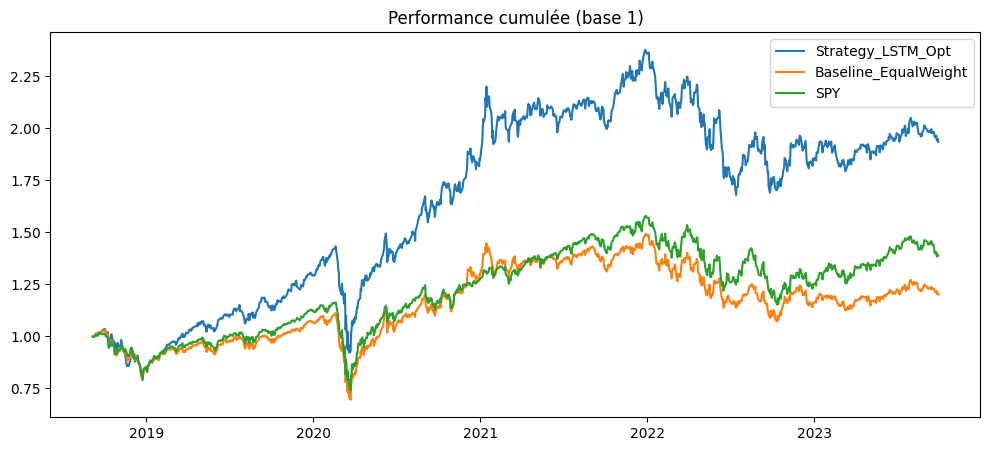

✅ Metrics (annualized):
Strategy_LSTM_Opt => {'AnnReturn': np.float64(0.1467), 'AnnVol': np.float64(0.2416), 'Sharpe': np.float64(0.6071), 'MaxDrawdown': -0.3575}
Baseline_EqualWeight => {'AnnReturn': np.float64(0.0384), 'AnnVol': np.float64(0.2251), 'Sharpe': np.float64(0.1705), 'MaxDrawdown': -0.3757}
SPY => {'AnnReturn': np.float64(0.0704), 'AnnVol': np.float64(0.2152), 'Sharpe': np.float64(0.3272), 'MaxDrawdown': -0.3647}


,Strategy_LSTM_Opt,Baseline_EqualWeight,SPY
Date,,,
2018-09-06,-0.003623,-0.000049,-0.003015
2018-09-07,0.002231,0.001389,-0.001946
2018-09-10,0.001605,0.000102,0.001737
2018-09-11,0.003660,0.003377,0.003292
2018-09-12,0.002945,0.003342,0.000242


In [18]:
# ============================================================
# COMPARE vs SPY (plot + simple metrics)
# ============================================================

def get_spy_returns(start, end):
    spy = yf.download("SPY", start=start, end=end, auto_adjust=False, progress=False)["Adj Close"]
    spy_ret = np.log(spy).diff().dropna()
    spy_ret.name = "SPY"
    return spy_ret

def perf_metrics(r, freq=252):
    r = r.dropna()
    if len(r) == 0:
        return {}
    ann_ret = np.exp(r.mean()*freq) - 1
    ann_vol = r.std()*np.sqrt(freq)
    sharpe  = ann_ret / (ann_vol + 1e-12)
    mdd = (np.exp(r.cumsum()) / np.exp(r.cumsum()).cummax() - 1).min()
    return {"AnnReturn": ann_ret, "AnnVol": ann_vol, "Sharpe": sharpe, "MaxDrawdown": mdd}

def plot_vs_spy(strategy, baseline):
    start = min(strategy.index.min(), baseline.index.min())
    end = max(strategy.index.max(), baseline.index.max()) + pd.Timedelta(days=1)

    spy_ret = get_spy_returns(start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))

    df_cmp = pd.concat([strategy, baseline, spy_ret], axis=1).dropna()
    cum = np.exp(df_cmp.cumsum())

    plt.figure(figsize=(12,5))
    plt.plot(cum.index, cum["Strategy_LSTM_Opt"], label="Strategy_LSTM_Opt")
    plt.plot(cum.index, cum["Baseline_EqualWeight"], label="Baseline_EqualWeight")
    plt.plot(cum.index, cum["SPY"], label="SPY")
    plt.title("Performance cumulée (base 1)")
    plt.legend()
    plt.show()

    # metrics
    print("✅ Metrics (annualized):")
    for col in df_cmp.columns:
        m = perf_metrics(df_cmp[col])
        print(col, "=>", {k: round(v, 4) for k, v in m.items()})

    return df_cmp

df_cmp = plot_vs_spy(strategy_daily, baseline_daily)
display(df_cmp.head())


# 18) Metrics de performance (Annual return, Volatilité, Sharpe, Max Drawdown)

On calcule quelques métriques classiques sur les rendements journaliers (log-returns) :
- **Annual Return** (approx.)
- **Annual Volatility**
- **Sharpe Ratio** (RF ≈ 0)
- **Max Drawdown**


In [19]:
# ============================================================
# 20) METRICS (Sharpe, vol, drawdown)
# ============================================================
df_comp = pd.concat([strategy_daily, baseline_daily], axis=1).dropna()

def perf_metrics(log_returns, freq=252):
    r = log_returns.dropna()
    if len(r) == 0:
        return pd.Series({"AnnReturn": np.nan, "AnnVol": np.nan, "Sharpe": np.nan, "MaxDrawdown": np.nan})

    # Annualized return from log-returns: exp(mean_log*freq)-1
    ann_ret = np.exp(r.mean() * freq) - 1

    # Annualized vol
    ann_vol = r.std(ddof=0) * np.sqrt(freq)

    # Sharpe (RF ~ 0)
    sharpe = (r.mean() * freq) / (ann_vol + 1e-12)

    # Max Drawdown from equity curve
    equity = np.exp(r.cumsum())
    dd = equity / equity.cummax() - 1
    mdd = dd.min()

    return pd.Series({
        "AnnReturn": ann_ret,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "MaxDrawdown": mdd
    })

# df_comp doit contenir Strategy, Baseline et SPY (si tu as utilisé le plot_vs_spy)
metrics = pd.DataFrame({
    col: perf_metrics(df_comp[col])
    for col in df_comp.columns
}).T

# plus lisible en %
metrics_fmt = metrics.copy()
metrics_fmt["AnnReturn"] = (100 * metrics_fmt["AnnReturn"]).round(2)
metrics_fmt["AnnVol"] = (100 * metrics_fmt["AnnVol"]).round(2)
metrics_fmt["Sharpe"] = metrics_fmt["Sharpe"].round(2)
metrics_fmt["MaxDrawdown"] = (100 * metrics_fmt["MaxDrawdown"]).round(2)

print(" Metrics (%):")
display(metrics_fmt)


 Metrics (%):


,AnnReturn,AnnVol,Sharpe,MaxDrawdown
Strategy_LSTM_Opt,14.62,24.14,0.57,-35.75
Baseline_EqualWeight,3.69,22.50,0.16,-37.57


In [20]:
# ============================================================
# 21) EXPORT FOR STREAMLIT
# ============================================================
df1_roles.to_parquet("df1_roles.parquet")
pred_df.to_parquet("predictions.parquet")
df_comp.to_csv("backtest_daily.csv")

print("Saved: df1_roles.parquet, predictions.parquet, backtest_daily.csv")

Saved: df1_roles.parquet, predictions.parquet, backtest_daily.csv
